## What is the shape of South African Higher Education?

In November 2017, a piece by Nomalanga Mkhize on the [parlous state of undergraduate higher education in South Africa](http://www.dispatchlive.co.za/opinion/2017/11/21/time-deal-higher-educations-dirtiest-secret/) was published on Dispatch Live. It was followed soon after with a [discussion](http://life.primedia.co.za/podcasts/134/episode/39940) on Koketso Sachane's radio show and a small slurry of emails between myself and UdubsNET colleagues.

One of the pieces I came across in the course of the discussion was Vivienne Bozalek and Chrissie Boughey's [(Mis)framing Higher Education in South Africa](http://onlinelibrary.wiley.com/doi/10.1111/j.1467-9515.2012.00863.x/abstract), which examines SA higher education policy from the perspective of Nancy Fraser's normative framework of social justice. Underlying that discussion of social justice was brief discussion of the shape and structure of South African Higher Education, drawing on Nico Cloete and Peter Mbali's 2010 [presentation](http://www.cepd.org.za/files/HESummit_Commission4_Differentiation.pdf) on differentiation in the sector. This also reminded me of the classification David Cooper used in his [2015 article](http://doi.wiley.com/10.1111/hequ.12074). 

Using the CHET's [South African Higher Education Open Data](http://www.chet.org.za/data/sahe-open-data) I set myself two questions:

1. What patterns and thus groupings are visible in South African higher education (and do the Cloete & Mbali and Cooper classifications hold up)?

2. What can we learn from trends and associations in the data?

In particular here I'm animated by two motives. Firstly, I want to understand the story of South African higher education. I want to become familiar with the data and techniques for working with that data. Secondly, I want to trouble that story. To see the rough edges and elisions.

To start, I collected 9 variables (input and output) drawn from [Cloete and Mbati](http://www.cepd.org.za/files/HESummit_Commission4_Differentiation.pdf).

Input variables:
* %’s headcount enrolment in SET
* M&D headcount enrolments
* student: academic staff FTE ratios
* permanent staff with doctoral degrees
* private income 
* government student fee income per student

Output variables:
* success rate
* graduation rate
* weighted research output by permanent staff member

The data used was retrieved from [CHET's SA Higher Education Performance Data](http://www.chet.org.za/data/sahe-open-data). Apologies for the over-large gaps in the presentation - the gaps hide computer code that was used for data analysis. If you are interested in that aspect of things have a look at the [Jupyter notebook](http://nbviewer.jupyter.org/github/pvanheus/chet_data_exploration/blob/master/notebooks/CHETdata.ipynb).

#### A note on graduation rates

The CHET data didn't include graduation rates, only number of graduates. The graduation rate is a crude statistic, it only measures how many graduations there are as a proportion of total students enrolled. As the [2015 DHET annual report](http://www.dhet.gov.za/DHET%20Statistics%20Publication/Statistics%20on%20Post-School%20Education%20and%20Training%20in%20South%20Africa%202015.pdf) notes, if the number of students enrolled is growing, it will push down the apparent graduation rate. So these are not great measures of throughput or dropout rate. More discussion on graduation rates is in the CHE's [Education Monitor #9](http://www.che.ac.za/sites/default/files/publications/Higher_Education_Monitor_9.pdf).

One of the problems with graduation rate is that it is calculated by comparing the number of graduates in the year to the same year's enrollment. If year on year enrollment increases it artificially deflates the graduation rate. And if year on year enrollment decreases it artificially inflates that rate. The CHET data *Table 2* shows, for instance, that UNIVEN grew between 2011 and 2015, and WSU shrank.

Unsatisfied with just comparing the number of graduates with the number of enrolled students, I decided to chase another figure, one for which the data is easier to access: what is the percentage when you compare the number of students who were enrolled for a 3 year degree or diploma in 2013 to those who graduated in 2015? I know many students in South Africa take more than 3 years to graduate. In fact many are enrolled in 4 year "extended curriculum" programmes. Still, for those who did enroll for a 3 year course, it is instructive to see how many graduates there were 3 years later. Not perfect, but instructive. I use this "3 year course graduation rate" for my analysis. I'm not sure what Cloete & Mbati used.

Working on this graduation data was one of the least satisfying part of this data analysis, because it was so imprecise. Besides the limitations discussed above, one of the things to note is that distance programmes have a much higher non-completion rate than contact programmes. The DHET sets its undergraduate graduation rate target for 25% for contact programmes and 15% for distance programmes. Even with that in mind, UNISA's about 8% graduation rate is poor. And only a handful of institutions achieve the 25% target set by the DHET for contact programmes.

#### Postgraduate student proportion

In one other respect I different from Cloete & Mbati's figures. They used the number of Masters and Doctoral students enrolled. I use the number of postgraduates as a proportion of the student population.

In [1]:
import pandas
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist
import requests
import zipfile
import holoviews as hv
from bokeh.palettes import colorblind

%matplotlib inline

data_directory = '../data'

# fetch the CHET data file
zipped_CHET_file = 'SA_HE_2015_Data.zip'
zipped_CHET_data_url = 'http://www.chet.org.za/files/uploads/data/2017/' + zipped_CHET_file
r = requests.get(zipped_CHET_data_url)
with open(data_directory + '/' + zipped_CHET_file, 'wb') as output:
    output.write(r.content)
zip_ref = zipfile.ZipFile(data_directory + '/' + zipped_CHET_file, 'r')
zip_ref.extractall(data_directory)
zip_ref.close()

enrollment_spreadsheet = data_directory + '/Table 4 Enrolments by CESM and Major Field of Study 2015.xlsx'

data = pandas.read_excel(enrollment_spreadsheet, skiprows=35,
                         index_col=0)
total_university_enrollment = data['TOTAL']['Total']
data = data[1:]

#### Overall enrollment in Higher Education in SA, 2015

In [2]:
data

,Undergraduate,PG < Masters,Masters,Doctorate,TOTAL
Major Field of Study,,,,,
Natural sciences,117401.668,7626.000,9846.166,5683.666,140557.500
Engineering and technology,83967.916,2498.416,6737.250,1695.500,94899.082
Health sciences,43577.583,4569.500,9178.667,2152.000,59477.750
"Business, economic and management sciences",236557.334,23538.334,11592.417,2140.000,273828.085
Education,134434.751,30529.834,3427.083,2158.000,170549.668
Humanities and social sciences,209710.750,15740.915,14764.418,5683.833,245899.916
Unknown,0.000,0.000,0.000,0.000,0.000
Total,825650.002,84502.999,55546.001,19512.999,985212.001


In [3]:
# total enrollment in SET subjects
print("Total enrollment in Science, Engineering and Technology (SET)", sum(data.loc[['Natural sciences', 'Engineering and technology', 'Health sciences'],'TOTAL']))

Total enrollment in Science, Engineering and Technology (SET) 294934.332


In [4]:
def get_enrollment_stats(filename, sheet_name):
    data = pandas.read_excel(filename, sheet_name=sheet_name, header=None)
    institution_name = data.iloc[0,0]
    rows_to_skip = data[data[0] == 'Major Field of Study'].index[0]
    data = pandas.read_excel(filename, sheet_name=sheet_name, skiprows=rows_to_skip, index_col=0)
    data.drop(data.index[0])
    SET_enrollment = sum(data.loc[['Natural sciences', 'Engineering and technology', 'Health sciences'],'TOTAL'])
    total_enrollment = data.loc['Total', 'TOTAL']
    m_and_d_enrollment = int(data.loc[['Total'], ['Masters ', 'Doctorate']].sum(axis=1))
    return institution_name, { 'SET percentage': SET_enrollment / total_enrollment, 
                                'M and D enrollment': m_and_d_enrollment,
                                 'Total enrollment': total_enrollment}
    

book = pandas.ExcelFile(enrollment_spreadsheet)
enroll_dict = dict()
for sheet_name in book.sheet_names[1:]:
    enroll = get_enrollment_stats(enrollment_spreadsheet, sheet_name)
    uni_name_code = enroll[0]
    uni_code = uni_name_code.split()[0]
    uni_name = uni_name_code.split(' - ', maxsplit=1)[1].strip()
    enroll_stats = enroll[1]
    enroll_stats['University Name'] = uni_name
    enroll_dict[uni_code] = enroll_stats
overall_data = pandas.DataFrame.from_dict(enroll_dict, orient='index')

headcount_spreadsheet = data_directory + '/Table 1 Student Headcounts and FTEs.xlsx'

student_to_staff_ratio_spreadsheet = data_directory + '/Table 17 Ratio of Student FTEs to Staff FTEs.xlsx'

data = pandas.read_excel(student_to_staff_ratio_spreadsheet, skiprows=7, index_col=0)
data = data.iloc[1:-1]
data.index = data.index.str.strip()
student_to_staff_2015 = data[2015]
student_to_staff_2015.name = 'Student To Staff Ratio'
overall_data = pandas.concat([overall_data, student_to_staff_2015],axis=1)

staff_qualifications_spreadsheed = data_directory + '/Table 13 Staff Qualifications.xlsx'

column_names = ['University', 'University Name', 'Doctors', 'Masters', 'Other',
       'Total', 'Doctors.1', 'Masters.1', 'Other.1', 'Total.1', 'Doctors.2',
       'Masters.2', 'Other.2', 'Total.2', 'Doctors.3', 'Masters.3', 'Other.3',
       'Total.3', 'Doctors.4', 'Masters.4', 'Other.4', 'Total.4', 'Doctors.5',
       'Masters.5', 'Other.5', 'Total.5', 'Doctors.6', 'Masters.6', 'Other.6',
       'Total.6']

data = pandas.read_excel(staff_qualifications_spreadsheed, skiprows=8, index_col=0, names=column_names)
data = data[:-1]
data.index = data.index.str.strip()
staff_with_phd_2015 = data.loc[:,['Doctors.6', 'Total.6']]
staff_with_phd_2015['% Academic Staff with PhD'] = staff_with_phd_2015['Doctors.6'].div(
    staff_with_phd_2015['Total.6'])
staff_with_phd_2015.columns = ['Staff with PhD', 'Total Academic Staff', '% Academic Staff with PhD']
overall_data = pandas.concat([overall_data, staff_with_phd_2015], axis=1)

income_source_spreadsheet = data_directory + '/Table 22 Sources of Income.xlsx'

data = pandas.read_excel(income_source_spreadsheet, skiprows=8, index_col=0)
data.index = data.index.str.strip()
data = data[:-1]
private_income_percentage = data['Private income.6']
private_income_percentage.name = 'Private income %'
overall_data = pandas.concat([overall_data, private_income_percentage], axis=1)

fee_income_per_fte_spreadsheed = data_directory + '/Table 26 Formal Tution Fee Income per FTE.xlsx'

data = pandas.read_excel(fee_income_per_fte_spreadsheed, skiprows=7, index_col=0)
data.index = data.index.str.strip()
data = data[1:-1]
tuition_and_fee_income_per_fte_2015 = data[2015]
tuition_and_fee_income_per_fte_2015.name = 'Tuition and Fee Income Per FTE Student'
overall_data = pandas.concat([overall_data, tuition_and_fee_income_per_fte_2015], axis=1)

I chose drop the data for SPU, UMP and SMHSU. These universities were founded in 2014, 2014 and 2015 respectively, and data for them is incomplete.

In [5]:
# these are the codoes for the 3 institutions where we lack decent output variables
institutions_to_drop = ['H23', 'H24', 'H26']
overall_data = overall_data.drop(institutions_to_drop)
overall_data = overall_data.drop('Total Academic Staff', axis=1)
overall_data = overall_data.drop('Staff with PhD', axis=1)

abbreviations = [name.split(' - ')[0] if name != 'University of Pretoria' else 'UP' for name in 
                overall_data['University Name']]
overall_data['Abbreviation'] = abbreviations

success_rate_spreadsheet = data_directory + '/Table 7 Success Rates.xlsx'

data = pandas.read_excel(success_rate_spreadsheet, skiprows=7, index_col=0)
data = data[1:-1]
data.index = data.index.str.strip()
data = data.drop(institutions_to_drop)

overall_data["Success Rate"] = data[2015]

graduate_rate_spreadsheet = data_directory + '/graduation_data.csv'

graduation_numbers_spreadsheet = data_directory + '/Table 8 Graduates by Qualification Type.xlsx'
enrollment_numbers_spreadsheet = data_directory + '/Table 3 Enrolment by Qualification Type.xlsx'

graduation_data = pandas.read_excel(graduation_numbers_spreadsheet, skiprows=194, index_col=0)
graduation_data = graduation_data[1:-1]
graduation_data.index = graduation_data.index.str.strip()
graduation_data = graduation_data.drop(institutions_to_drop)
graduation_data_columns_to_keep = ['Total undergraduate (UG)', 'Total postgraduate (PG)', 'Total']
graduation_data = graduation_data.loc[:, graduation_data_columns_to_keep]

enrollment_data = pandas.read_excel(enrollment_numbers_spreadsheet, skiprows=194, index_col=0)
enrollment_data =  enrollment_data[1:-1]
enrollment_data.index = enrollment_data.index.str.strip()
enrollment_data = enrollment_data.drop(institutions_to_drop)
enrollment_data_columns_to_keep = ['Total Undergraduate (UG)', 'Total Postgraduate (PG)', 'Total']
enrollment_data = enrollment_data.loc[:, enrollment_data_columns_to_keep]
enrollment_data.columns = graduation_data_columns_to_keep

crude_graduation_rate = graduation_data.div(enrollment_data)
postgraduate_percentage = enrollment_data['Total postgraduate (PG)'] / (
    enrollment_data['Total postgraduate (PG)'] + enrollment_data['Total undergraduate (UG)'])
crude_graduation_rate.columns = ['Undergraduate Graduation Rate %', 'Postgraduate Graduation Rate %',
                                'Total Graduation Rate %']
crude_graduation_rate['Percentage Postgraduate'] = postgraduate_percentage
overall_data['Percentage Postgraduate'] = postgraduate_percentage
crude_graduation_rate = pandas.concat([overall_data['University Name'], crude_graduation_rate], axis=1)

enrollment_data_2013 = pandas.read_excel(enrollment_numbers_spreadsheet, skiprows=132, index_col=0)
enrollment_data_2013 = enrollment_data_2013[1:27]
enrollment_data_2013.index = enrollment_data_2013.index.str.strip()
enrollment_data_2013 = enrollment_data_2013.drop(institutions_to_drop)
enrollment_data_2013_columns_to_keep = ['UG Dipl/Cert (3yrs)', '1st B Degree (3yrs)']
enrollment_data_2013.columns
enrollment_data_2013 = enrollment_data_2013.loc[:, enrollment_data_2013_columns_to_keep].fillna(0)
enrollment_data_2013["3 year UG enrollment"] = enrollment_data_2013.iloc[:,0] + enrollment_data_2013.iloc[:,1]

graduation_data_3yrUG = pandas.read_excel(graduation_numbers_spreadsheet, skiprows=194, index_col=0)
graduation_data_3yrUG = graduation_data_3yrUG[1:-1]
graduation_data_3yrUG.index = graduation_data_3yrUG.index.str.strip()
graduation_data_3yrUG = graduation_data_3yrUG.drop(institutions_to_drop)
graduation_data_3yrUG = graduation_data_3yrUG.loc[:, enrollment_data_2013_columns_to_keep].fillna(0)
graduation_data_3yrUG["3 year UG graduation"] = graduation_data_3yrUG.iloc[:,0] + graduation_data_3yrUG.iloc[:,1]

three_year_graduation_rate = pandas.concat([graduation_data_3yrUG['3 year UG graduation'].div(
    enrollment_data_2013['3 year UG enrollment']), overall_data['University Name']], axis=1)
three_year_graduation_rate.columns = ['3 year course graduation rate', 'University Name']
overall_data['3yr Graduation Rate'] = three_year_graduation_rate['3 year course graduation rate']

research_outputs_per_academic_spreadsheet = data_directory + '/Table 19 Weighted Total Research Output per Permanent Academic Staff.xlsx'

data = pandas.read_excel(research_outputs_per_academic_spreadsheet, skiprows=7, index_col=0)
data = data[1:-1]
data.index = data.index.str.strip()
data.drop('H26')
research_outputs_data = data[2015]
overall_data['WRO per Academic'] = research_outputs_data

### Principal Components Analysis and K-means clustering

The Cloete and Mbati's presentation they group universities into three groups, red, green and blue. Firstly I want to know if the data supports that grouping. To that end I'm going to use two tools, principal component analysis and k-means clustering.

[Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) statistical technique to make data easier to visualise and interpret. The data we have thus far is 9 variables for each of 23 higher education institutions. I want to get a picture in 2 dimensions, so I use PCA to combine the variables into 2 principal components of variance.

Secondly, I want to assign each of the universities to one of a number of classes. To this end, I use another statistical tool, [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering). I choose some number, $k$, and then try and find this number of clusters in the data. In the plot below I've combined chosen $k = 4$ and coloured each resulting group. I've also added crosses for the "centroids". These are the "centers" of each cluster.


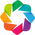

In [6]:
hv.extension('bokeh')

In [7]:
%%opts Scatter [height=600 width=600 size_index=2 scaling_factor=500]
%%opts Points (marker='x' size=15)
%%opts Table [height=600]
%%opts Overlay [legend_limit=30]

share_of_students = overall_data['Total enrollment'].div(total_university_enrollment)

columns_to_exclude = ['University Name', 'Abbreviation', 'M and D enrollment', 'Total enrollment']
plotting_data = overall_data.drop(columns_to_exclude, axis=1)

plotting_data_std = StandardScaler().fit_transform(plotting_data)
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(plotting_data_std)
pca_data = pandas.DataFrame(Y_sklearn, index=overall_data.index, columns=('PCA1', 'PCA2'))
pca_data['Student Share'] = share_of_students

model = KMeans(n_clusters=4).fit(pca_data)
df_with_kmeans = pca_data.copy()
df_with_kmeans['group'] = model.labels_
df_with_kmeans['name'] = overall_data['University Name']
df_with_kmeans['abbreviation'] = overall_data['Abbreviation']

extra_extent_x = 1
extra_extent_y = 0.15
max_x = df_with_kmeans['PCA1'].max()
max_x += extra_extent_x
min_x = df_with_kmeans['PCA1'].min()
min_x -= extra_extent_x
max_y = df_with_kmeans['PCA2'].max()
max_y += extra_extent_y
min_y = df_with_kmeans['PCA2'].min()
min_y -= extra_extent_y

palette = [hv.Cycle('Colorblind').values[i] for i in (7,3,4,6,2,5)]
scatters = []
for i in range(df_with_kmeans['group'].max() + 1):
    data = df_with_kmeans[df_with_kmeans['group'] == i]
    scatters.append(hv.Scatter(data,
                               vdims=['PCA2','Student Share'], 
                               label='Group {}'.format(i+1),
                               extents=(min_x, min_y, max_x, max_y)).opts(style=dict(color=palette[i])))
scatter = hv.Overlay(scatters)

points = hv.Points(model.cluster_centers_, label='centroids').opts(
    style=dict(color=hv.Cycle('Colorblind').values[5]))
offset_x = (scatter.range('PCA1')[1] - scatter.range('PCA1')[0]) * 0.05
offset_y = 2

plot = scatter * points
texts = []
for i, label in enumerate(overall_data.index):
    x = df_with_kmeans['PCA1'][i] + offset_x + offset_x * df_with_kmeans['Student Share'][i]*3
    y = df_with_kmeans['PCA2'][i]
    plot *= hv.Text(x, y, df_with_kmeans['abbreviation'][i])
plot

:Overlay
   .Scatter.Group_1  :Scatter   [PCA1]   (PCA2,Student Share)
   .Scatter.Group_2  :Scatter   [PCA1]   (PCA2,Student Share)
   .Scatter.Group_3  :Scatter   [PCA1]   (PCA2,Student Share)
   .Scatter.Group_4  :Scatter   [PCA1]   (PCA2,Student Share)
   .Points.Centroids :Points   [x,y]
   .Text.I           :Text   [x,y]
   .Text.II          :Text   [x,y]
   .Text.III         :Text   [x,y]
   .Text.IV          :Text   [x,y]
   .Text.V           :Text   [x,y]
   .Text.VI          :Text   [x,y]
   .Text.VII         :Text   [x,y]
   .Text.VIII        :Text   [x,y]
   .Text.IX          :Text   [x,y]
   .Text.X           :Text   [x,y]
   .Text.XI          :Text   [x,y]
   .Text.XII         :Text   [x,y]
   .Text.XIII        :Text   [x,y]
   .Text.XIV         :Text   [x,y]
   .Text.XV          :Text   [x,y]
   .Text.XVI         :Text   [x,y]
   .Text.XVII        :Text   [x,y]
   .Text.XVIII       :Text   [x,y]
   .Text.XIX         :Text   [x,y]
   .Text.XX          :Text   [x,y]
   .Text.XXI         :Text   [x,y]
   .Text.XXII        :Text   [x,y]
   .Text.XXIII       :Text   [x,y]

(Scale of dots corresponds with share of the total national student enrollment.)

The PCA shows us some kind of clustering, but it doesn't show what variables have been summarised into the principal components. The 4 groups are as follows:

1. UP, UCT, SU, WITS and RU.
2. UJ, NWU, NMU, UKZN, UWC, FH and FS
3. CPUT, TUT, VUT, MUT, DUT, CUT, UL, WSU, UZ and UNIVEN
4. UNISA

The first group corresponds with the "red" group in Cloete & Mbali's presentation. They also correspond closely with the upper band in Cooper's paper - the only difference being that Cooper includes UKZN, not RU and moves RU to the second band. 

The second group corresponds fairly closely with Cooper's middle band. UNISA and RU are here in Cooper's classification, whereas in my PCA UNISA is in its own group and RU is in group 1. There is some correspondence as well with Cloete & Mbali's "green" group, but they include UL and UZ, which end up in group 3 in the PCA.

The third group is contains the universities of technology along with UL, WSU, UZ and UNIVEN.

How well does this grouping fit the data? One way to answer that is to count the sum of distances between the group centroids and the group members. Doing this for various values of $k$ gives what is called an elbow plot, included below. 

In [8]:
def elbow_plot(dataframe, k_values):
    distortions = []
    k_values = list(range(2,20))
    for k in k_values:
        model = KMeans(n_clusters=k).fit(dataframe)
        model.labels_
        distortion = sum(np.min(cdist(dataframe, 
                                      model.cluster_centers_, 'euclidean'), axis=1)) / dataframe.shape[0]
        distortions.append(distortion)
    plt.plot(k_values, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.xticks(range(2,21))

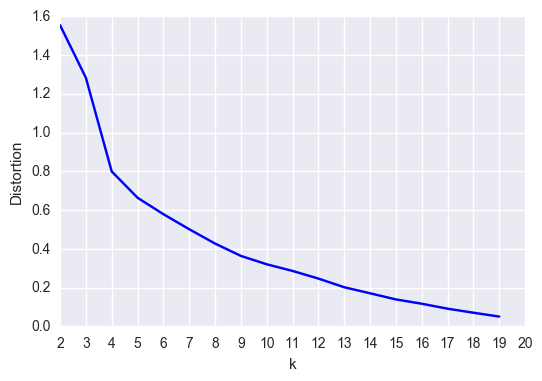

In [9]:
elbow_plot(pca_data, list(range(2,20)))

The thing to look for in a elbow plot is a "kink", i.e. a point at which the rate at which the distortion is changes distinctly. There is a small kink at 4, so $k=4$ is a reasonably choice. Of course within the grouping there are differences. Below is an example of a plot with $k=6$. Is this a better classification than the $k=4$ one?

In [10]:
%%opts Scatter [height=600 width=600 size_index=2 scaling_factor=500]
%%opts Points (marker='x' size=15)
%%opts Table [height=600]
%%opts Overlay [legend_limit=30]

share_of_students = overall_data['Total enrollment'].div(total_university_enrollment)

columns_to_exclude = ['University Name', 'Abbreviation', 'M and D enrollment', 'Total enrollment']
plotting_data = overall_data.drop(columns_to_exclude, axis=1)

plotting_data_std = StandardScaler().fit_transform(plotting_data)
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(plotting_data_std)
pca_data = pandas.DataFrame(Y_sklearn, index=overall_data.index, columns=('PCA1', 'PCA2'))
pca_data['Student Share'] = share_of_students

model = KMeans(n_clusters=6).fit(pca_data)
df_with_kmeans = pca_data.copy()
df_with_kmeans['group'] = model.labels_
df_with_kmeans['name'] = overall_data['University Name']
df_with_kmeans['abbreviation'] = overall_data['Abbreviation']

extra_extent_x = 1
extra_extent_y = 0.15
max_x = df_with_kmeans['PCA1'].max()
max_x += extra_extent_x
min_x = df_with_kmeans['PCA1'].min()
min_x -= extra_extent_x
max_y = df_with_kmeans['PCA2'].max()
max_y += extra_extent_y
min_y = df_with_kmeans['PCA2'].min()
min_y -= extra_extent_y

palette = [hv.Cycle('Colorblind').values[i] for i in (7,3,4,6,2,5)]
scatters = []
for i in range(df_with_kmeans['group'].max() + 1):
    data = df_with_kmeans[df_with_kmeans['group'] == i]
    scatters.append(hv.Scatter(data,
                               vdims=['PCA2','Student Share'], 
                               label='Group {}'.format(i+1),
                               extents=(min_x, min_y, max_x, max_y)).opts(style=dict(color=palette[i])))
scatter = hv.Overlay(scatters)

points = hv.Points(model.cluster_centers_, label='centroids').opts(
    style=dict(color=hv.Cycle('Colorblind').values[5]))
offset_x = (scatter.range('PCA1')[1] - scatter.range('PCA1')[0]) * 0.05
offset_y = 2

plot = scatter * points
texts = []
for i, label in enumerate(overall_data.index):
    x = df_with_kmeans['PCA1'][i] + offset_x + offset_x * df_with_kmeans['Student Share'][i]*3
    y = df_with_kmeans['PCA2'][i]
    plot *= hv.Text(x, y, df_with_kmeans['abbreviation'][i])
plot

:Overlay
   .Scatter.Group_1  :Scatter   [PCA1]   (PCA2,Student Share)
   .Scatter.Group_2  :Scatter   [PCA1]   (PCA2,Student Share)
   .Scatter.Group_3  :Scatter   [PCA1]   (PCA2,Student Share)
   .Scatter.Group_4  :Scatter   [PCA1]   (PCA2,Student Share)
   .Scatter.Group_5  :Scatter   [PCA1]   (PCA2,Student Share)
   .Scatter.Group_6  :Scatter   [PCA1]   (PCA2,Student Share)
   .Points.Centroids :Points   [x,y]
   .Text.I           :Text   [x,y]
   .Text.II          :Text   [x,y]
   .Text.III         :Text   [x,y]
   .Text.IV          :Text   [x,y]
   .Text.V           :Text   [x,y]
   .Text.VI          :Text   [x,y]
   .Text.VII         :Text   [x,y]
   .Text.VIII        :Text   [x,y]
   .Text.IX          :Text   [x,y]
   .Text.X           :Text   [x,y]
   .Text.XI          :Text   [x,y]
   .Text.XII         :Text   [x,y]
   .Text.XIII        :Text   [x,y]
   .Text.XIV         :Text   [x,y]
   .Text.XV          :Text   [x,y]
   .Text.XVI         :Text   [x,y]
   .Text.XVII        :Text   [x,y]
   .Text.XVIII       :Text   [x,y]
   .Text.XIX         :Text   [x,y]
   .Text.XX          :Text   [x,y]
   .Text.XXI         :Text   [x,y]
   .Text.XXII        :Text   [x,y]
   .Text.XXIII       :Text   [x,y]

With $k=6$, what Cloete & Mbati labeled as the "red" group splits apart, with a new group forming around KZN, NWU, UP and RU, and the original "red" group being reduced to the tight cluster of WITS, SU and UCT. The "green" group is split, FH, FS, UJ and UWC remaining together in another tight cluster. The "blue" group also splits, with TUT, UZ, WSU and VUT departing from CUT, UL, CPUT, UNIVEN, DUT and MUT. UNISA remains in a group of its own.

What informs this classification? To shed some light on that I used a [Sequential Feature Selector](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/) to highlight the variables that contributed most to group membership. With the selection of $k=6$, the variables chosen are:

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

knn = KNeighborsClassifier(n_neighbors=23)
X = plotting_data_std
y = df_with_kmeans['group'].values

sfs1 = SFS(knn, 
           k_features=3, 
           forward=True, 
           floating=True, 
           verbose=0,
           scoring='accuracy',
           cv=0)

sfs1 = sfs1.fit(X, y)
for i in sfs1.subsets_[3]['feature_idx']:
    print(plotting_data.columns[i])

SET percentage
Student To Staff Ratio
% Academic Staff with PhD


In [12]:
# the code below was used to examine the impact of a choice of k for neighbours

# def knn_elbow_plot(X, y):
#     cv_scores = []
#     k_values = list(range(1,24,2))
#     for k in k_values:
#         knn = KNeighborsClassifier(n_neighbors=k)
        
#         sfs1 = SFS(knn, 
#                    k_features=3, 
#                    forward=True, 
#                    floating=False, 
#                    verbose=0,
#                    scoring='accuracy',
#                    cv=0)
#         sfs1 = sfs1.fit(X, y)
#         cv_score = sfs1.k_score_
#         cv_scores.append(cv_score)
#     print(cv_scores)
#     plt.plot(k_values, cv_scores, 'bx-')
#     plt.xlabel('k')
#     plt.ylabel('Distortion')
#     plt.xticks(k_values)
# X = plotting_data_std

# y = df_with_kmeans['group'].values
# knn_elbow_plot(X, y)

i.e. what distinguishes these institutions? The proportion of students enrolled in SET (Science, Engineering and Technology) subjects, the ratio of students to academic staff and the percentage of academic staff who have a PhD. Effectively these are three distinct axes of variance.

A different perspective on the data is: what variables correlate? I.e. what varies together between universities?The heat map below shows the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between all pairs of variables in the data.

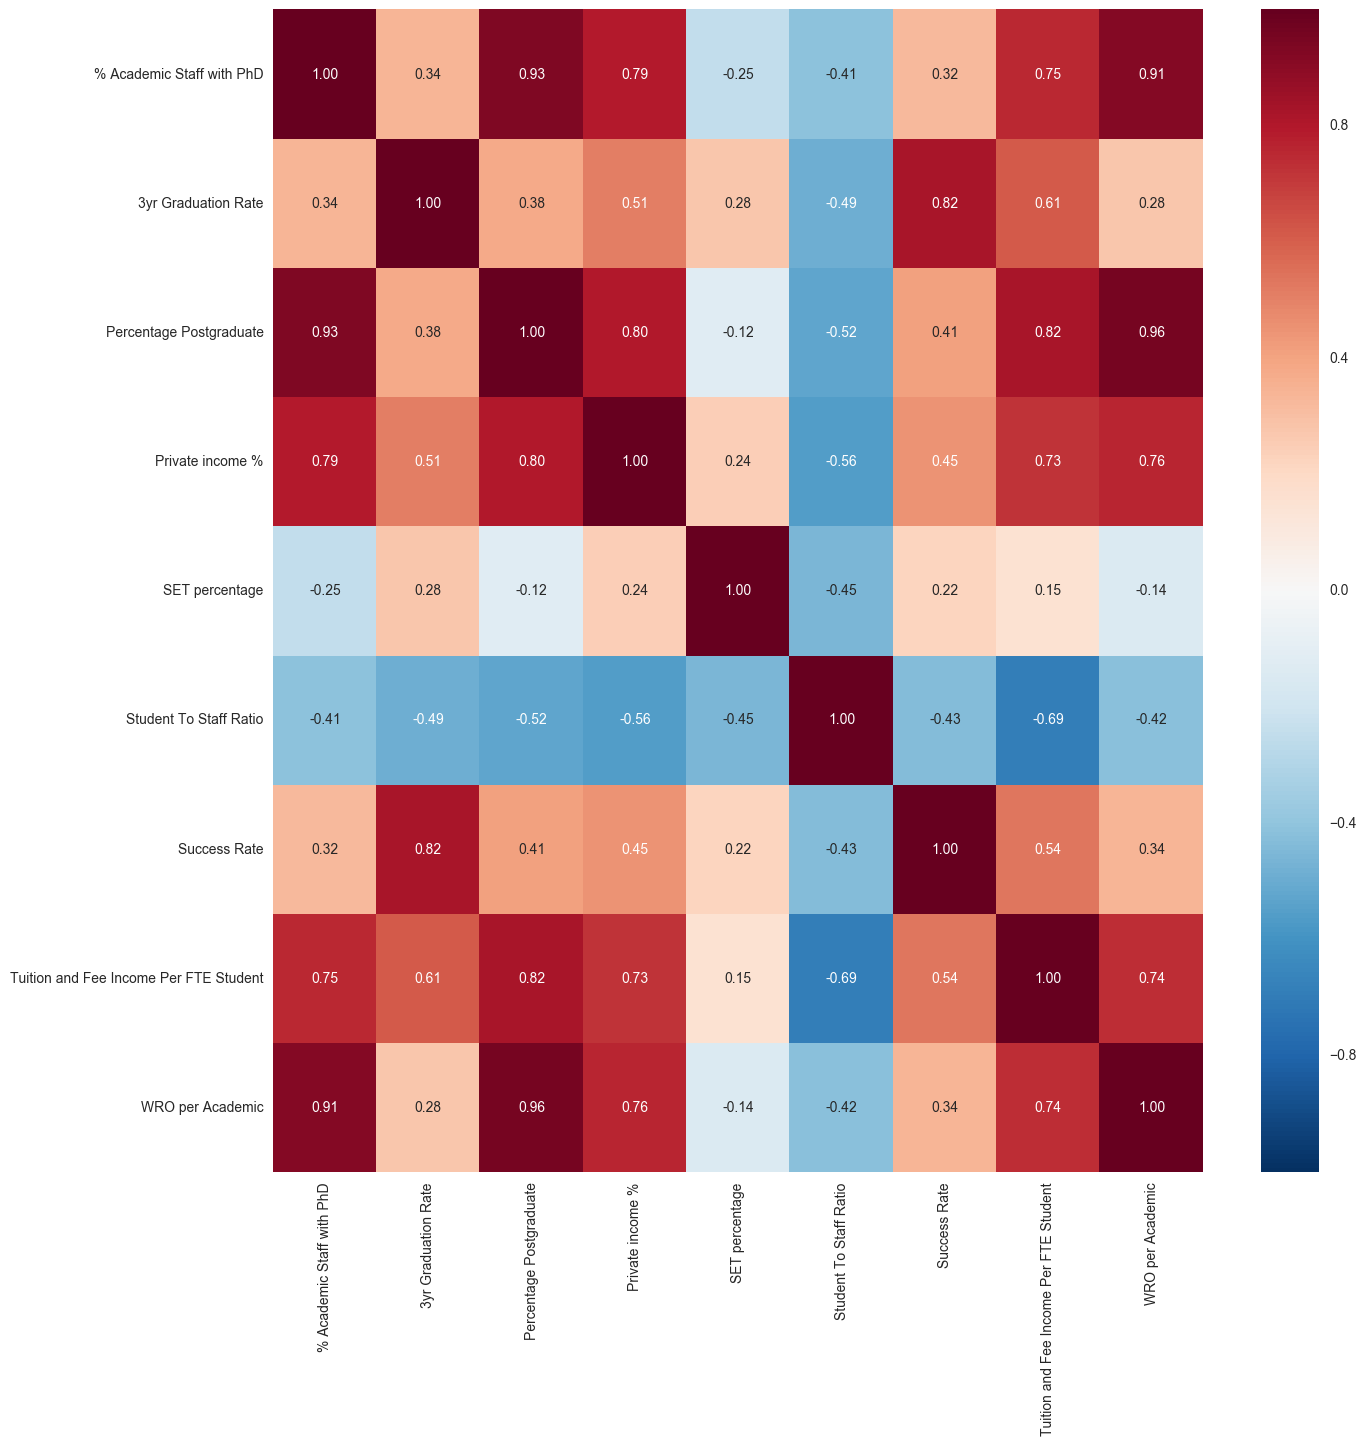

In [13]:
plotting_data = overall_data.loc[:,overall_data.columns.difference(columns_to_exclude)]
plt.figure(figsize=(15, 15))
sns.heatmap(plotting_data.corr(), annot=True, fmt=".2f")

What correlates? Let's look at this from 2 perspectives: firstly the "research university" perspective:

*Weighted Research Output per Academic staff member* strongly correlates with *Percentage Postgraduate*, *Private income %*, *Staff with PhD*, *Tuition Fee Income Per FTE Student*. There is a negative correlation with *Student to Staff Ratio* but it is at -0.42, so not as strong as the positive correlations. This is all evidence for the existence of a well funded "Postgrad and Research System". Interestingly, there is a weak correlation between research  output and *3yr Graduation Rate*, suggesting that undergraduate success is not necessary for research success. This might be evidence of divided universities, where the "Postgrad and Research System" does not entirely rely on the university's own undergraduate teaching mission. Postgrads and skilled staff can be (and are) recruited outside the system.

Secondly, the *undergraduate performance* perspective. Here the year on year *Success Rate* and the *3yr Graduation Rate* are the things to look at. The two measures correlate with each other - not surprisingly, since graduate requires year on year success. For both of these measures there are correlations with *Private income %* and *Tuition Fee Income Per FTE Student* - better resourced universities are more successful at graduating students - the correlation is not especially strong though. There is also an inverse correlation with *Student to Staff Ratio*, again not a terribly strong one though. I'd hazard a guess that there are missing factors, factors that can more strongly explain the undergraduate success story (or lack thereof).

Note that in the above data there is no information on race, class, gender, university location and a host of other socio-economic factors. I incorporate some of that below. First though, a look at the values of each variable.

I've plotted each variable in the dataset. Some interesting patterns here:

1. The SET (Science, Engineering & Technology) subjects are - not surprisingly - most prominent in the Universities of Technology.
2. As noted previously, David Cooper's 3-class classification based on papers per academic per year still holds up. There are 5 universities with more than 2 papers per academic per year: UP, SU, RU, UKZN, and Wits. FH is nipping on their heels, but watch out - according to [Mouton et al, 2017](http://www.sajs.co.za/extent-south-african-authored-articles-predatory-journals/johann-mouton-astrid-valentine) about a quarter of UFH's research output is being published in what might be predatory journals. Quite worrying is that of the 10 institutions (MUT, WSU, VUT, CPUT, CUT, TUT, UZ, DUT, UNIVEN and UL) with 1 paper per academic per year or below, 8 also publish 10% of more of their research output in journals that might be predatory (only VUT and TUT miss out this "predatory list").
3. The top 5 "research intensive" universities mostly are also those with lowest student to staff ratios. UP is the exception here, as it is in the lower half of the list.
4. The top graphs are all strongly differentiated. They measure "objectively measurable" things like income, income source, staff to student ratio, staff with PhDs, proportion of students who are postgraduates. Something surprising happens with the last 2 graphs - the 3 year graduation rate, and the "success rate". Even if my calculations on the graduation rate are suspicious, the success rate is an officially recorded number: how many students progress at the end of their academic year. The fact that almost all universities record a 80% or better success rate (the national benchmark is apparently 80%) leaves me wondering what is going on.

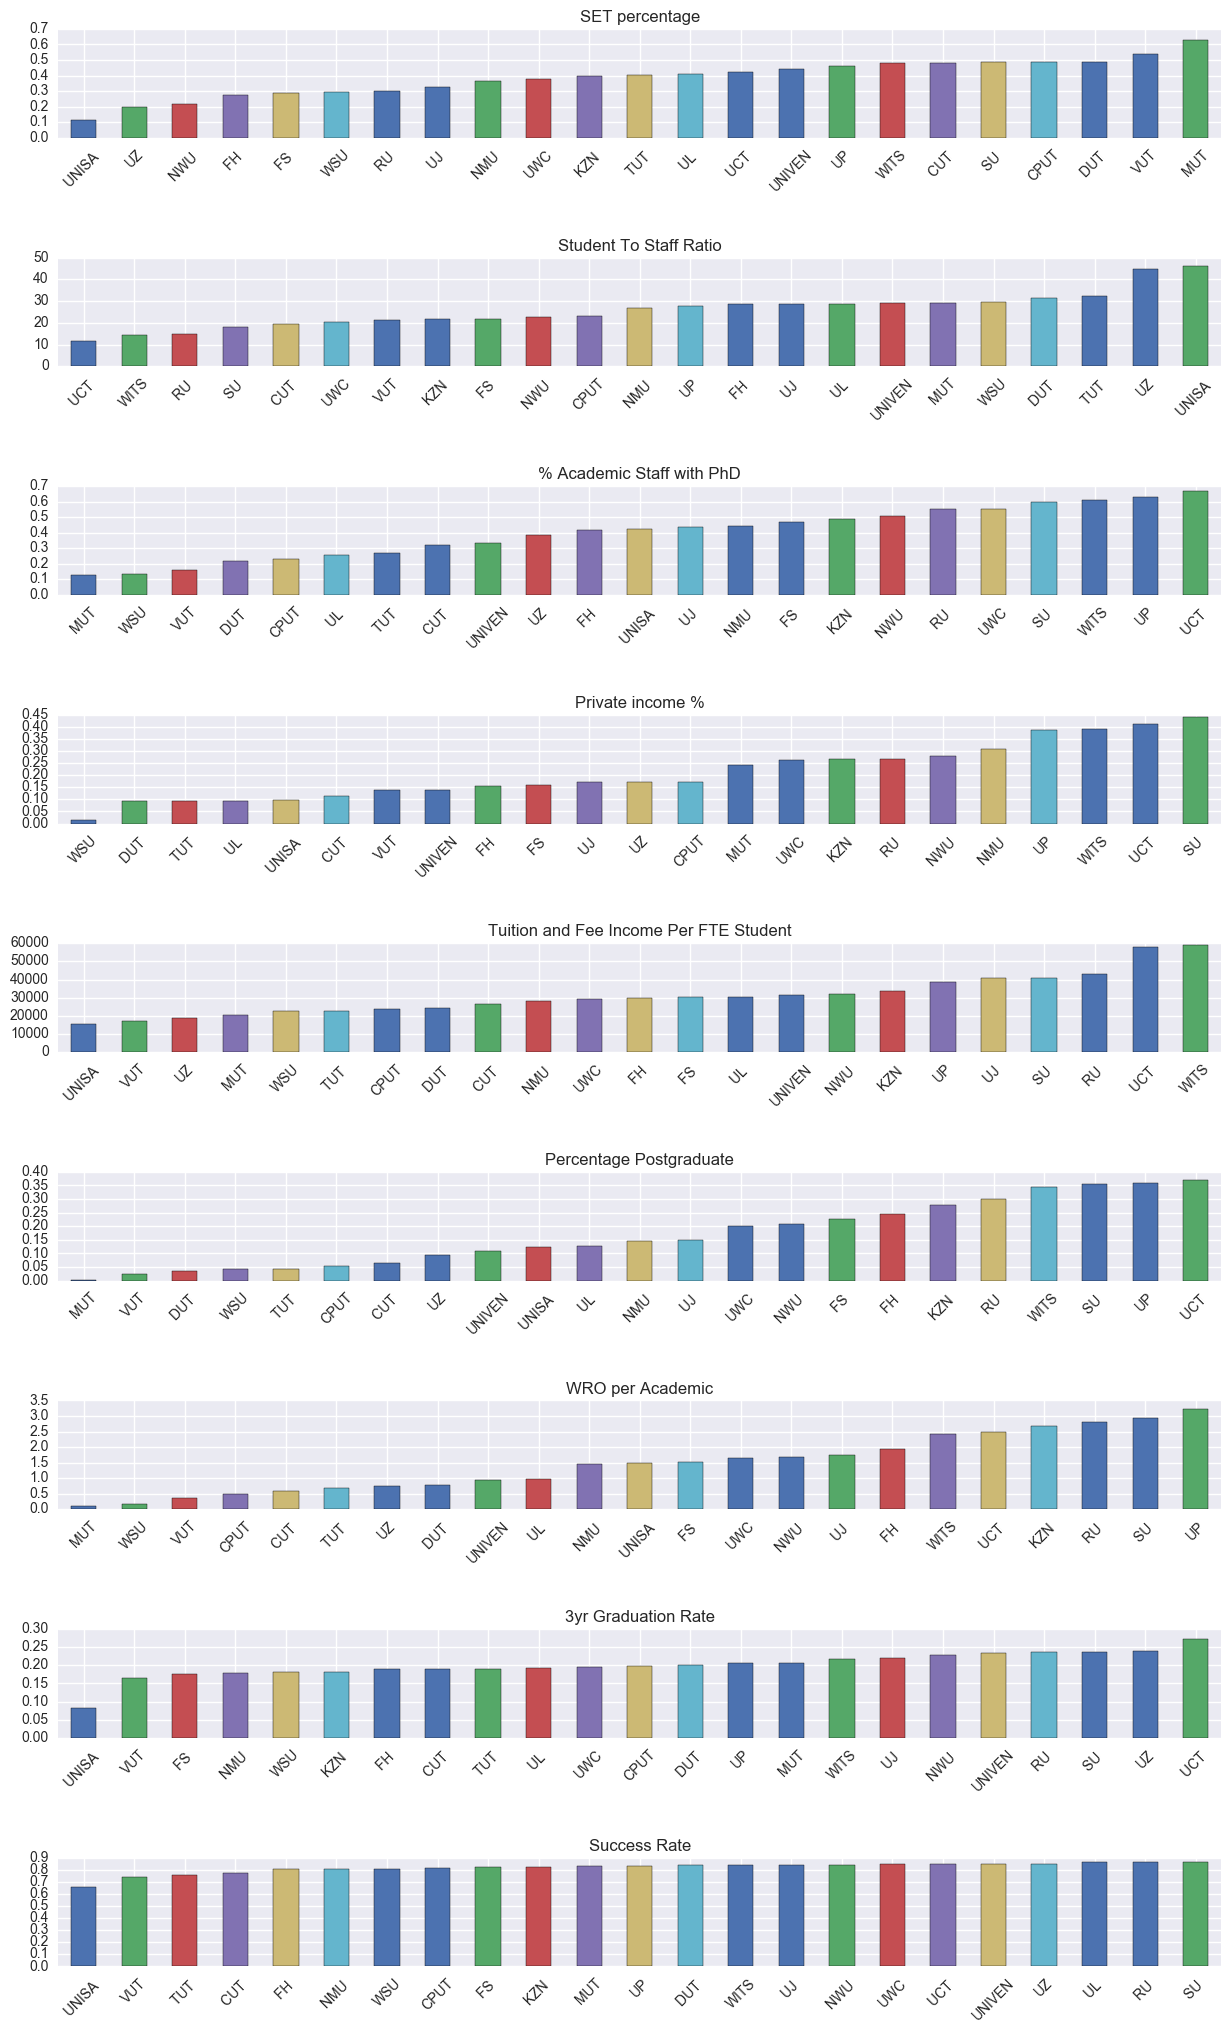

In [14]:
enrollment_race_spreadsheet = data_directory + '/Table 5 Total Enrolments by Race.xlsx'

data = pandas.read_excel(enrollment_race_spreadsheet, skiprows=8, index_col=0, usecols="A,AN:AS")
data = data[1:-1].fillna(0)
data.index = data.index.str.strip()
data = data.drop(institutions_to_drop)
race_ratios = data.iloc[:,:-1].div(data['Total'], axis=0)
race_ratios.columns = [name + ' %' for name in race_ratios.columns]
overall_data = pandas.concat([overall_data, race_ratios], axis=1)

plt.figure(figsize=(15,15))

# columns_to_plot = list(overall_data.columns)
# del columns_to_plot[0]
# del columns_to_plot[1]
columns_to_plot = ['SET percentage',
       'Student To Staff Ratio', '% Academic Staff with PhD', 'Private income %',
       'Tuition and Fee Income Per FTE Student',
       'Percentage Postgraduate', 'WRO per Academic', '3yr Graduation Rate', 'Success Rate']
#         'African  %', 'Coloured %', 'Indian %', 'White %', 'Unknown %']
f, axarr = plt.subplots(len(columns_to_plot), figsize=(15,25))
f.subplots_adjust(hspace=1.1)
for i, column_name in enumerate(columns_to_plot):
    temp_data = overall_data[column_name]
    temp_data.index = [(name.split(' - ')[0] if name != 'University of Pretoria' 
                        else 'UP') for name in list(overall_data['University Name'])]
    temp_data.sort_values().plot(rot=45, kind='bar', ax=axarr[i], title=column_name)
    axarr[i].set_xlabel('')
#     if i < len(columns_to_plot) - 1:
#         axarr[i].tick_params(
#             axis='x',          # changes apply to the x-axis
#             which='both',      # both major and minor ticks are affected
#             bottom='off',      # ticks along the bottom edge are off
#             top='off',         # ticks along the top edge are off
#             labelbottom='off') # labels along the bottom edge are off

What then about race? In the following heat map I've added the proportion of students in the different racial categories to the next heat map.

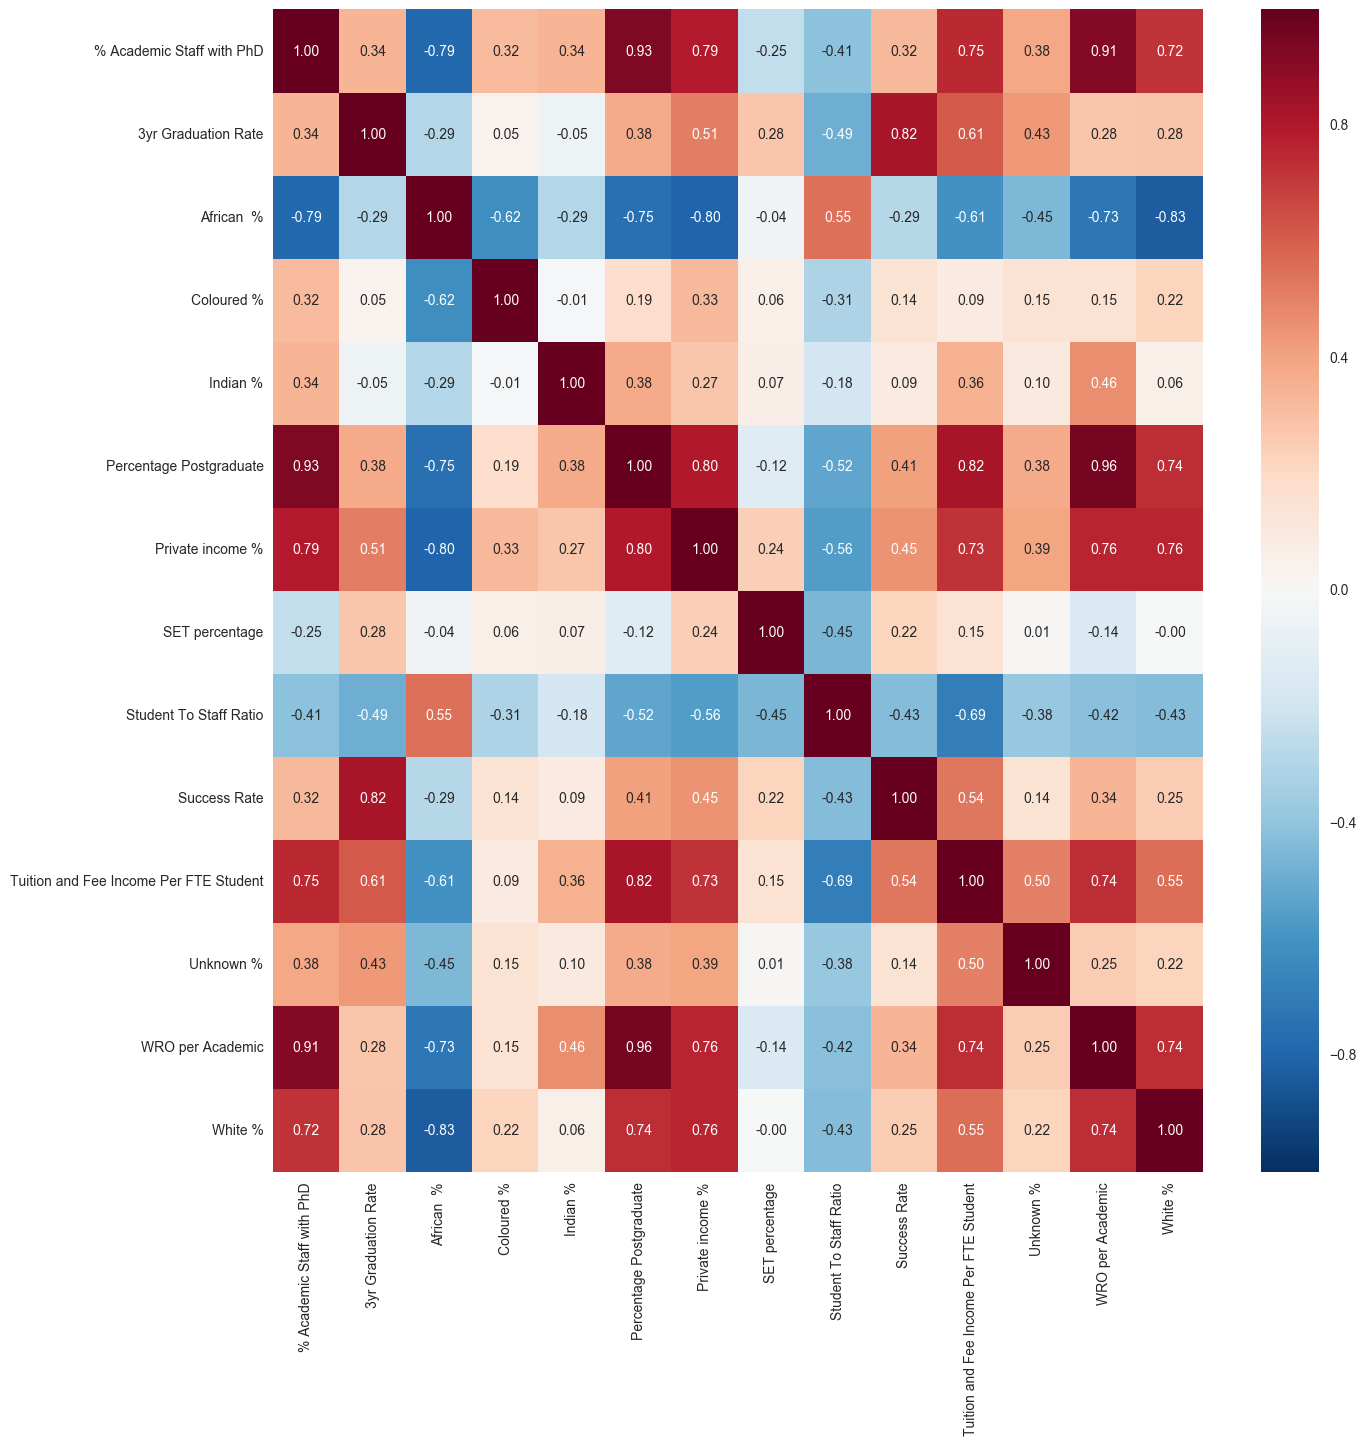

In [15]:
columns_to_exclude.append('M and D enrollment')
plotting_data = overall_data.loc[:,overall_data.columns.difference(columns_to_exclude)]
plt.figure(figsize=(15, 15))
sns.heatmap(plotting_data.corr(), annot=True, fmt=".2f")

Finally added ratios of students by race to the data. What can we see?

1. Of the 4 racial groups (not counting Unknown), institutions with high percentage of African students have a weak negative correlation with poor undergraduate result markers (*3yr Graduation Rate* and *Success Rate*). Conversely institutions with a high % of white students correlate weakly with good undergraduate result markers. There's no significant correlation for the other 2 ratial groups.
2. Higher % of white students correlates positively with what I previously called the "Postgraduate and Research System" markers. Conversely, higher % of African students correlates negatively with these markers. 
3. Higher Student to Staff ratio correlates with higher % of African students.

Below I show the proportions of students of the different racial categories at the different institutions.

In [16]:
%%opts Bars.Stacked [height=600 width=800 stack_index='Group' legend_position='top' xrotation=45]
 from itertools import product

bargraph_data = []
for elements in product(overall_data.sort_values(by='White %', ascending=False)['Abbreviation'], ['Coloured %', 
                                                       'African  %', 'Indian %', 'White %', 'Unknown %']):
    bargraph_data.append((elements[0], elements[1], 
                          overall_data[overall_data['Abbreviation'] == elements[0]][elements[1]].values[0]))
bars = hv.Bars(bargraph_data,
               ['Index', 'Group'], 'Proportion')
bars.relabel(group='Stacked')

:Bars   [Index,Group]   (Proportion)

I do not know what the large proportion of "Unknown" students at UCT are. Besides that complication, the pattern of shows what is apparent from the correlation data: high proportions of white students are found in the institutions with high postgraduate presence and high research output (and high income and fees). Conversely the institutions with the highest proportion of African students are also ones that are mostly undergraduate universities with restricted funding options. Again, it is very surprising that the "success rate" is so similar between such disparate institutions.

In [17]:
# %%opts Scatter [height=600 width=600] (size=8)
# %%opts Points (marker='x' size=15)
# %%opts Table [height=600]
# %%opts Overlay [legend_limit=30]

# plotting_data = overall_data.drop(columns_to_exclude, axis=1)

# plotting_data_std = StandardScaler().fit_transform(plotting_data)
# sklearn_pca = sklearnPCA(n_components=2)
# Y_sklearn = sklearn_pca.fit_transform(plotting_data_std)
# pca_data = pandas.DataFrame(Y_sklearn, index=overall_data.index, columns=('PCA1', 'PCA2'))
# model = KMeans(n_clusters=4).fit(pca_data)
# df_with_kmeans = pca_data.copy()
# df_with_kmeans['group'] = model.labels_
# df_with_kmeans['name'] = overall_data['University Name']
# df_with_kmeans['abbreviation'] = overall_data['Abbreviation']

# extra_extent_x = 1
# extra_extent_y = 0.15
# max_x = df_with_kmeans['PCA1'].max()
# max_x += extra_extent_x
# min_x = df_with_kmeans['PCA1'].min()
# min_x -= extra_extent_x
# max_y = df_with_kmeans['PCA2'].max()
# max_y += extra_extent_y
# min_y = df_with_kmeans['PCA2'].min()
# min_y -= extra_extent_y

# palette = [hv.Cycle('Colorblind').values[i] for i in (7,3,4,6,2,4)]
# scatters = []
# print(df_with_kmeans['group'].max())
# for i in range(df_with_kmeans['group'].max() + 1):
#     data = df_with_kmeans[df_with_kmeans['group'] == i]
#     scatters.append(hv.Scatter(data,
#                                vdims=['PCA2'], 
#                                label='Group {}'.format(i+1),
#                                extents=(min_x, min_y, max_x, max_y)).opts(style=dict(color=palette[i])))
# scatter = hv.Overlay(scatters)

# points = hv.Points(model.cluster_centers_, label='centroids').opts(
#     style=dict(color=hv.Cycle('Colorblind').values[5]))
# offset_x = (scatter.range('PCA1')[1] - scatter.range('PCA1')[0]) * 0.05
# offset_y = 2

# plot = scatter * points
# texts = []
# for i, label in enumerate(overall_data.index):
#     x = df_with_kmeans['PCA1'][i] + offset_x
#     y = df_with_kmeans['PCA2'][i]
#     plot *= hv.Text(x, y, df_with_kmeans['abbreviation'][i])

# plot

In [18]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.datasets import load_iris
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# knn = KNeighborsClassifier(n_neighbors=21)
# X = plotting_data_std

# y = df_with_kmeans['group'].values

# sfs1 = SFS(knn, 
#            k_features=3, 
#            forward=True, 
#            floating=False, 
#            verbose=0,
#            scoring='accuracy',
#            cv=0)

# sfs1 = sfs1.fit(X, y)
# for i in sfs1.subsets_[3]['feature_idx']:
#     print(plotting_data.columns[i])
# sfs1.k_score_

In [19]:
# def knn_elbow_plot(X, y):
#     cv_scores = []
#     k_values = list(range(1,24,2))
#     for k in k_values:
#         knn = KNeighborsClassifier(n_neighbors=k)
        
#         sfs1 = SFS(knn, 
#                    k_features=3, 
#                    forward=True, 
#                    floating=False, 
#                    verbose=0,
#                    scoring='accuracy',
#                    cv=0)
#         sfs1 = sfs1.fit(X, y)
#         cv_score = sfs1.k_score_
#         cv_scores.append(cv_score)
#     print(cv_scores)
#     plt.plot(k_values, cv_scores, 'bx-')
#     plt.xlabel('k')
#     plt.ylabel('Distortion')
#     plt.xticks(k_values)
# X = plotting_data_std

# y = df_with_kmeans['group'].values
# knn_elbow_plot(X, y)

### Conclusions

Three things stand out for me in the data analysis above. 

Firstly the data supports the ranking of a small number of historically white (and advantaged) universities in what David Cooper calls the "upper band" of research intensive universities. Beyond this, of the nine variables that Nico Cloete and Peter Mbati use in differentiating institutions of higher education, five share a strong positive correlation, with weighted research output per permanent staff member (the origin of Cooper's three bands) being within that group. Its worth noting that this "upper band" is comprised of five Historically White Universities (HWUs) that remained independent during the period of university mergers in the 2000s.

Secondly, Cloete and Mbati's variables do not strongly differentiate universities in terms of undergraduate performance. While graduation rates and success rates differ (although less so for success rates), these are both imperfect measures if the goal is to understand overall undergraduate performance, especially the throughput and dropout rates of undergraduates, let alone their ultimate fate in the employment market. A decade ago Ian Scott, Nan Yeld and Jane Hendry [noted](http://www.che.ac.za/media_and_publications/higher-education-monitor/higher-education-monitor-6-case-improving-teaching) that "the fact that sector-wide longitudinal performance data have only recently become available suggests that focusing on the collective output [i.e. undergraduate graduation] of the sector has historically not been a priority". Arguably the situation a decade later is not much improved.

Thirdly, the impact of race on the picture is stark. The "upper band" universities tend to have far higher proportions of white students and, leaving aside the universities of technology, those universities that are weakest in terms of the five research output correlated variables all have overwhelmingly African students.

Overall the data paints a picture of a strongly differentiated higher education system. As Scott, Yeld and Hendry note, "differentiation is probably inevitable and there is no doubt value and creativity in diversification of mission, there are arguments that intensifying or formalising differentiation in the South African context would not be in the interests of the educational obligations of the sector." Differentiation in terms of educational mission, for example between universities of technology and comprehensive universities, or between distance learning and contact learning, can be considered "diversification of mission". The other axes of differentiation noted above have no such saving graces. Cultivating a small number of "research universities" that also are historically advantaged universities and better resourced universities is a disservice to the transformative mission of the South African higher education system.

As Mkhize notes, higher education cannot afford to "chase the number" in terms of throughput and success rates at the cost of producing poorly qualified students. An undergraduate system that produces poorly qualified graduates cannot serve the need for strong postgraduate students and ultimately qualified academics. While, as noted above, there is an overall weakness in the data available to track the undergraduate part of the university, the weak correlation between what undergraduate performance numbers exist and postgraduate and research measures indicates that we might be facing a "two tier" higher education system that poorly articulates between undergraduate and postgraduate phases.

As Bozalek and Boughey note "[t]he very foreclosure of the possibility of education as a whole not facilitating the social arrangements for successful study at university is itself a form of social injustice and social
exclusion of the position in which students, and particularly those at HBUs, find themselves." In this regard Scott, Yeld and Hendry's observation that "students are expected to perform at increasingly easy (‘accessible’) levels in the only external examination they write in their school careers explains many of the difficulties they face with higher education study." is both alarming and a challenge. Pressure to comply with certain levels of "output" while leaving the workings of the broader education system and of higher education unexamined contribute to both a danger of systematic failure (as Mkhize notes) and also a system where a minority of "high functioning" institutions perpetuate privilege by accepting that the majority of the country's population is destined for exclusion.

The list of references I've scattered around show this isn't a new or newly acknowledged problem. Why then its persistence? Some of that can be laid at an management culture that chases numbers. Besides that though, it is worth noting the repression of years of students protests (including the killing of Michael Makhabane at University of Durban Westville in 2000). Also those facing "the doubly inequitable situations of HBUs related to the paucity of resources and the lack of educational preparation of the students they enroll" (Bozalek and Boughey) are also systematically excluded from media coverage and discussion of higher education issues. Finally, systematic crisis in undergraduate education brings with it high levels of demoralisation amongst staff. Given the weaknesses of collective voices in the academic sector (staff are divided within and between institutions) a political agent taking up the kudgels on the issues raised above is absent.

This is a bleak situation. It is also, as the wave of protests of the past few years has proved, an explosive situation. I'm glad Nomalanga Mkhize has raised some tough issues. There is much more thinking, researching, talking and especially acting necessary to overcome the systemic failure she writes about.

In [20]:
# staff_types_spreadsheet = data_directory + '/Table 11 Number of staff all types.xlsx'

# # I don't use this data  in the final analysis, but it is interesting to look at the academic 
# # to total staff ratio
# data = pandas.read_excel(staff_types_spreadsheet, skiprows=8, index_col=0)
# data = data[1:-1]
# data.index = data.index.str.strip()
# academic_staff = data.loc[:,['Academic.6']]
# support_staff = data.loc[:,['Total.6']].values - data.loc[:,['Academic.6']].values
# total_staff = data.loc[:,['Total.6']]
# academic_staff_ratio = pandas.Series(data=(
#     academic_staff.values / total_staff.values).squeeze(), index=data.index, name='Academic Staff %')
# academic_staff_ratio_data = pandas.concat(
#     [data, academic_staff_ratio], axis=1).loc[:,['University ', 
#                                                  'University Name ', 'Academic Staff %', 'Total.6']]
# academic_staff_ratio_data.index = academic_staff_ratio_data.loc[:,'University ']
# academic_staff_ratio_data = academic_staff_ratio_data.drop('University ', axis=1)
# academic_staff_ratio_data.sort_values(
#     'Academic Staff %').loc[:,['Academic Staff %', 'Total.6']].plot(kind='bar',
#                                                                     subplots=True,
#                                                                     figsize=(15,5))

In [21]:
# overall_data